In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Path to folder containing the images
image_folder = "earth-terrain-height-and-segmentation-map-images"

# Define RGB-to-label mapping for segmentation map
terrain_classes = {
    (17, 141, 215): 0,  # Water
    (225, 227, 155): 1,  # Grassland
    (127, 173, 123): 2,  # Forest
    (185, 122, 87): 3,  # Hills
    (230, 200, 181): 4,  # Desert
    (150, 150, 150): 5,  # Mountain
    (193, 190, 175): 6   # Tundra
}

# Helper function to load and preprocess a single image set
def load_and_preprocess(base_name, image_size=(64, 64)):
    # Build file paths
    terrain_path = os.path.join(image_folder, f'{base_name}_t.png')
    height_path = os.path.join(image_folder, f'{base_name}_h.png')
    segmentation_path = os.path.join(image_folder, f'{base_name}_i2.png')
    
    # Load images
    terrain_image = imread(terrain_path)
    height_image = imread(height_path)
    segmentation_image = imread(segmentation_path)
    
    # Resize images
    terrain_image = resize(terrain_image, image_size, anti_aliasing=True, preserve_range=True).astype('uint8')
    height_image = resize(height_image, image_size, anti_aliasing=True, preserve_range=True).astype('uint16')
    segmentation_image = resize(segmentation_image, image_size, anti_aliasing=True, preserve_range=True).astype('uint8')
    
    # Convert segmentation map to labels
    labels = np.apply_along_axis(
        lambda rgb: terrain_classes.get(tuple(rgb), -1), 2, segmentation_image
    ).flatten()
    
    # Filter out invalid labels (-1)
    valid_idx = labels != -1
    
    # Flatten and filter features
    terrain_flat = terrain_image.reshape(-1, terrain_image.shape[-1])[valid_idx]
    height_flat = height_image.flatten()[valid_idx]

    # Creating the 4D representation of [R, G, B, Height]
    features = np.hstack([terrain_flat, height_flat.reshape(-1, 1)])
    
    return features, labels[valid_idx]

# Function to process images in batches
def process_in_batches(batch_start, batch_end, image_size=(64, 64)):
    batch_features = []
    batch_labels = []
    for i in range(batch_start, batch_end + 1):
        base_name = f"{str(i).zfill(4)}"
        try:
            # Load and preprocess
            features, labels = load_and_preprocess(base_name, image_size=image_size)
            batch_features.append(features)
            batch_labels.append(labels)
        except FileNotFoundError:
            print(f"Image set {base_name} not found, skipping.")
        except Exception as e:
            print(f"Error processing {base_name}: {e}")
    # Combine batch into numpy arrays
    return np.vstack(batch_features), np.hstack(batch_labels)

# Process images in manageable batches
batch_size = 500  # Number of images per batch
total_images = 1000  # Total number of images
X = []
y = []

for batch_start in range(1, total_images + 1, batch_size):
    batch_end = min(batch_start + batch_size - 1, total_images)
    print(f"Processing batch: {batch_start} to {batch_end}")
    batch_X, batch_y = process_in_batches(batch_start, batch_end)
    X.append(batch_X)
    y.append(batch_y)

# Convert to single numpy arrays
X = np.vstack(X)
y = np.hstack(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Processing batch: 1 to 500
Processing batch: 501 to 1000


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Training loop with debug statements
acc = []
k_value = []

for k in range(1, 15):
    print(f"Training with k={k}...")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc_value = accuracy_score(y_test, y_pred)
    acc.append(acc_value)
    k_value.append(k)
    print(f"k={k}, Accuracy={acc_value:.4f}")



Training with k=1...
k=1, Accuracy=0.9954
Training with k=2...
k=2, Accuracy=0.9950
Training with k=3...
k=3, Accuracy=0.9962
Training with k=4...
k=4, Accuracy=0.9962
Training with k=5...
k=5, Accuracy=0.9963
Training with k=6...
k=6, Accuracy=0.9963
Training with k=7...
k=7, Accuracy=0.9963
Training with k=8...
k=8, Accuracy=0.9963
Training with k=9...
k=9, Accuracy=0.9963
Training with k=10...
k=10, Accuracy=0.9963
Training with k=11...
k=11, Accuracy=0.9963
Training with k=12...
k=12, Accuracy=0.9963
Training with k=13...
k=13, Accuracy=0.9963
Training with k=14...
k=14, Accuracy=0.9963


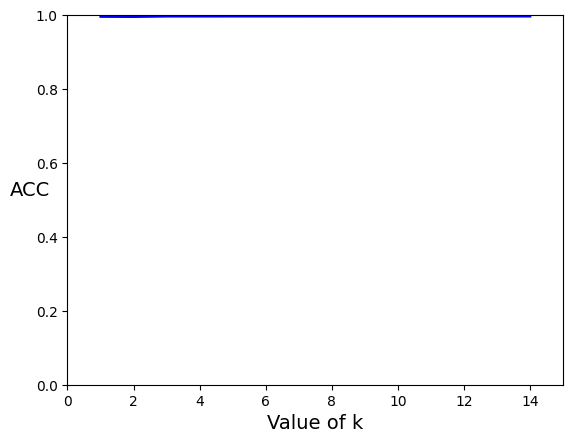

In [4]:
import matplotlib.pyplot as plt

# Plot results
indices = np.arange(1, 15)
plt.plot(indices, acc, "b-")
plt.xlabel("Value of k", fontsize=14)
plt.ylabel("ACC", fontsize=14, rotation=0)
plt.axis([0, 15, 0, 1])  # Adjusted plot range
plt.show()


Text(0, 0.5, 'Percent Error')

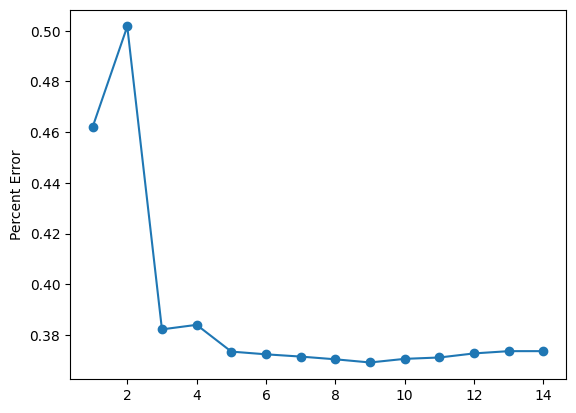

In [8]:
percent_error = [(1 - acc1) * 100 for acc1 in acc]
plt.plot(k_value, percent_error, marker='o')
plt.ylabel("Percent Error")
